# Loading Trials Data

In [1]:
# Turn off logging and disable tqdm this is a hidden cell on docs page
import logging
import os

logger = logging.getLogger('ibllib')
logger.setLevel(logging.CRITICAL)

os.environ["TQDM_DISABLE"] = "1"

Task related behavioral data

## Relevant Alf objects
* trials
* subjectTrials
* subjectTraining

## Loading a single session's trials


In [2]:
from one.api import ONE
one = ONE()
eid = '4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a'
trials = one.load_object(eid, 'trials', collection='alf')

For combining trials data with various recording modalities for a given session, the `SessionLoader` class is more convenient:

In [3]:
from brainbox.io.one import SessionLoader
from one.api import ONE
one = ONE()
eid = '4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a'
sl = SessionLoader(eid=eid, one=one)
sl.load_trials()

# The datasets are attributes of the sl.trials, for example probabilityLeft:
probabilityLeft = sl.trials['probabilityLeft']
# Find all of them using:
sl.trials.keys()

Index(['goCueTrigger_times', 'stimOff_times', 'probabilityLeft',
       'feedbackType', 'response_times', 'choice', 'firstMovement_times',
       'contrastLeft', 'contrastRight', 'stimOn_times', 'rewardVolume',
       'feedback_times', 'goCue_times', 'intervals_0', 'intervals_1'],
      dtype='object')

## Loading all the sessions' trials for a single subject at once
If you want to study several sessions for a single subject, we recommend you use the `one.load_aggregate` method rather than downloading each trials data individually per session.
This methods loads all the trials data `subjectTrials` for a given subject into a single DataFrame (i.e. all session trials are concatenated).
You can use the same method to load the `subjectTraining` table, which contains the training statuses.

In [ ]:
from one.api import ONE
one = ONE()
subject = 'SWC_043'
trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')

# Load training status and join to trials table
training = one.load_aggregate('subjects', subject, '_ibl_subjectTraining.table')
trials = (trials
          .set_index('session')
          .join(training.set_index('session'))
          .sort_values(by=['session_start_time', 'intervals_0']))
trials['training_status'] = trials.training_status.fillna(method='ffill')

# Join sessions table for number, task_protocol, etc.
trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')
if 'task_protocol' in trials:
    trials.drop('task_protocol', axis=1)
trials = trials.set_index('session').join(one._cache.sessions.drop('date', axis=1))

## More details
* [Description of trials datasets](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.nvzaz0fozs8h)
* [Description of task QC metrics](../_autosummary/ibllib.qc.task_metrics.html)

## Useful modules, packages and functions
* [brainbox.behavior.training](../_autosummary/brainbox.behavior.training.html)
* [psychofit](https://github.com/cortex-lab/psychofit/blob/master/Examples.ipynb)
* [brainbox.task.trials](../_autosummary/brainbox.task.trials.html)
* [ibllib.qc.task_metrics](../_autosummary/ibllib.qc.task_metrics.html)
* [brainbox.io.one.load_iti](../_autosummary/brainbox.io.one.html#brainbox.io.one.load_iti)

## Exploring trials data

### Example 1. Computing behavioral performance

In [4]:
from brainbox.behavior.training import compute_performance

# compute performance
performance, contrasts, n_contrasts = compute_performance(trials)

# compute performance expressed as probability of choosing right
performance, contrasts, n_contrasts = compute_performance(trials, prob_right=True)

# compute performance during 0.8 biased block
performance, contrasts, n_contrasts = compute_performance(trials, block=0.8)

### Example 2. Filtering trials

In [5]:
from brainbox.task.trials import find_trial_ids

# find index for stim right trials ordered by trial number
trial_id, _ = find_trial_ids(trials, side='right', choice='all', order='trial num')

# find index for correct, stim left, 100% contrast trials ordered by reaction time
trial_id, _ = find_trial_ids(trials, side='left', choice='correct', contrast=[1], order='reaction time')

# find index for correct trials ordered by trial number sorted by stimulus side
trial_id, _ = find_trial_ids(trials, side='left', choice='correct', order='reaction time', sort='side')

### Example 3. Plotting psychometric curve

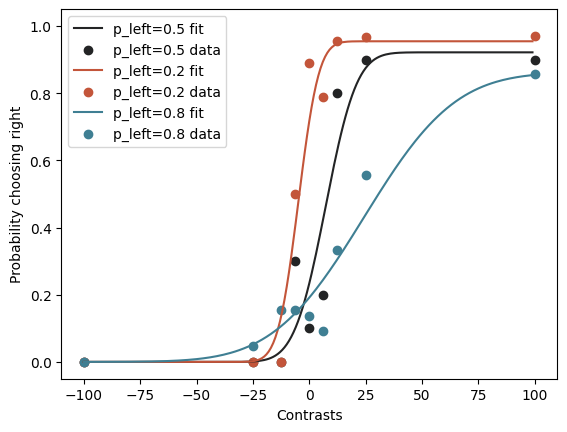

In [6]:
from brainbox.behavior.training import plot_psychometric

fig, ax = plot_psychometric(trials)

### Example 4: Computing Task QC for session

In [ ]:
from ibllib.qc import task_metrics

qc = task_metrics.TaskQC(eid)
outcome, results = qc.run()
print(f'QC_status: {outcome}')
print(f'Individual QC values:')
results

Information about individual qc checks can be found by looking at the docstring (replace `_task` with `check`), e.g.

In [ ]:
help(task_metrics.check_errorCue_delays)

### Example 5: Computing the inter-trial interval (ITI)
The ITI is the period of open-loop grey screen commencing at stimulus off and lasting until the
quiescent period at the start of the following trial.

In [7]:
from brainbox.io.one import load_iti
eid = 'ae8787b1-4229-4d56-b0c2-566b61a25b77'
trials = one.load_object(eid, 'trials')
trials['iti'] = load_iti(trials)
print(trials.to_df().iloc[:5, -5:])

   rewardVolume  firstMovement_times  intervals_0  intervals_1       iti
0           1.5           117.641626   116.695529   119.305634  1.191781
1           1.5           127.492626   119.997332   129.171944  1.223111
2           1.5           131.802626   129.895043   133.568441  1.202380
3           0.0           136.639626   134.270738   139.385252  1.255541
4           1.5           141.399626   140.140751   143.068359  1.167783


## Other relevant examples
* For examples of how to compute reaction time and or response time, see [Working with wheel data](./docs_wheel_moves.html).